## Notebook for retrieving statistical information from histograms

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
#from sklearn.mixture import GaussianMixture as GMM
from scipy import stats
import json
from scipy.stats import beta
import os

Folders where plots are saved: hurst_plots, cos_theta_plots, sim_cos_theta_plots

In [2]:
folders = ['hurst_plots', 'cos_theta_plots', 'sim_cos_theta_plots']
for f in folders:
    if not os.path.exists(f):
        os.makedirs(f)
        print('made folder ', f)

In [3]:
def get_dict_from_file(file_name, data_dict, step_sizes, window=None, restriction=None,
                       batch_number=None):
    """
    Reads in dictionary. data_dict can be 'h_dict', 'p_dict', 'cos_theta_dict', 'sim_cos_theta_dict'.
    """
    if data_dict == 'h_dict' or data_dict == 'p_dict':
        path = data_dict+'_data/'
        with open(path+data_dict+'_w{}_'.format(window)+'s{}_'.format(max(step_sizes))+'r{}_'.format(restriction)+file_name, 'r') as file:
            dictionary = file.read()
    elif data_dict == 'cos_theta_dict':
        path = 'cos_theta_dict_data/'
        with open(path+data_dict+'_'+file_name+'_s{}'.format(max(step_sizes))+'_b{}'.format(batch_number), 'r') as file:
            dictionary = file.read()
    elif data_dict == 'sim_cos_theta_dict':
        path = 'sim_pipe_cos_theta_data/'
        with open(path+data_dict+'_'+file_name+'_s{}'.format(max(step_sizes))+'_b{}'.format(batch_number), 'r') as file:
            dictionary = file.read()
    else:
        print('Invalid data_dict')

    return json.loads(dictionary)

def plot_3d(dictionary, all_step_sizes, n_bins, data_variable="H", absolute=False):
    
    %matplotlib notebook
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection="3d")
    cmap = plt.cm.inferno
    
    steps = [int(s) for s in list(dictionary)]
    yticks = np.array(steps)
    
    norm_counts, bins, sample_numbers = get_hist(dictionary,n_bins,absolute=absolute)

    for i,_ in enumerate(steps):
        ytick = yticks[i]
        temp_counts = norm_counts[i]
        temp_bins = bins[i]
        xcenter = np.convolve(temp_bins, np.ones(2), "valid")/2
        xwidth = np.diff(temp_bins)
        ax.bar(left=xcenter, height=temp_counts, width=xwidth, zs=ytick,
               zdir="y", color=cmap(i/len(yticks)), alpha=0.7, edgecolor="grey", linewidth=0.3)

    ax.set_xlabel("{}".format(data_variable))
    ax.set_ylabel("downsampling step size")
    ax.set_zlabel("p({})".format(data_variable))

    ax.set_yticks(yticks)
    plt.show()
    
    return norm_counts, bins, sample_numbers

def get_hist(dictionary, nbins,absolute=False):
    """
    """
    keys_list = list(dictionary)
    
    counts_all = np.empty((len(keys_list), nbins))
    bins_all = np.empty((len(keys_list), nbins+1))
    sample_number_all = np.empty((len(keys_list), 1))
    
    if absolute==False:
    
        for i,key in enumerate(keys_list):
            data = dictionary[key]
            sample_number = len(data)
            counts, bins = np.histogram(data, nbins, density=True)  # normalised so area under histogram is 1
            sample_number_all[i]= sample_number
            counts_all[i] = counts
            bins_all[i] = bins
    else:
        
        for i,key in enumerate(keys_list):
            data = dictionary[key]
            sample_number = len(data)
            counts, bins = np.histogram([abs(x) for x in data], nbins, density=True)  # normalised so area under histogram is 1
            sample_number_all[i]= sample_number
            counts_all[i] = counts
            bins_all[i] = bins

    return counts_all, bins_all, sample_number_all

In [4]:
filenames = np.array(['Control_frame001-200',
                      'Control_frame200-400',
                      'Control_frame400-600',
                      'Control_frame600-800',
                      'Control_frame800-1000',
                      'Control_frame1000-1200',
                      'LanB1_frame001-200',
                      'LanB1_frame200-400',
                      'LanB1_frame400-600',
                      'LanB1_frame600-800',
                      'LanB1_frame800-1000',
                      'LanB1_frame1000-1200',
                      'defLanB1_300817_frame200-400',
                      'defLanB1_300817_frame400-600'])

filenames_sim_stoch_hna00 = np.array(['stoch_h_hna0.00_r0.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r1.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r1.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r2.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r2.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r3.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r3.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r4.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r4.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r5.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r5.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r6.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r6.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r7.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r7.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r8.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r9.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r9.50_l200_mc250_cylinder_data'])

filenames_sim_stoch_hna05 = np.array(['stoch_h_hna0.50_r0.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r1.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r1.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r2.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r2.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r3.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r3.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r4.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r4.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r5.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r5.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r6.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r6.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r7.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r7.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r8.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r8.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r9.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.50_r9.50_l200_mc250_cylinder_data'])

In [5]:
step_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
sim_cos_theta_dict = get_dict_from_file(filenames_sim_stoch_hna00[2],'sim_cos_theta_dict',step_sizes,
                                        window=20,restriction=1000,batch_number=1)

<IPython.core.display.Javascript object>


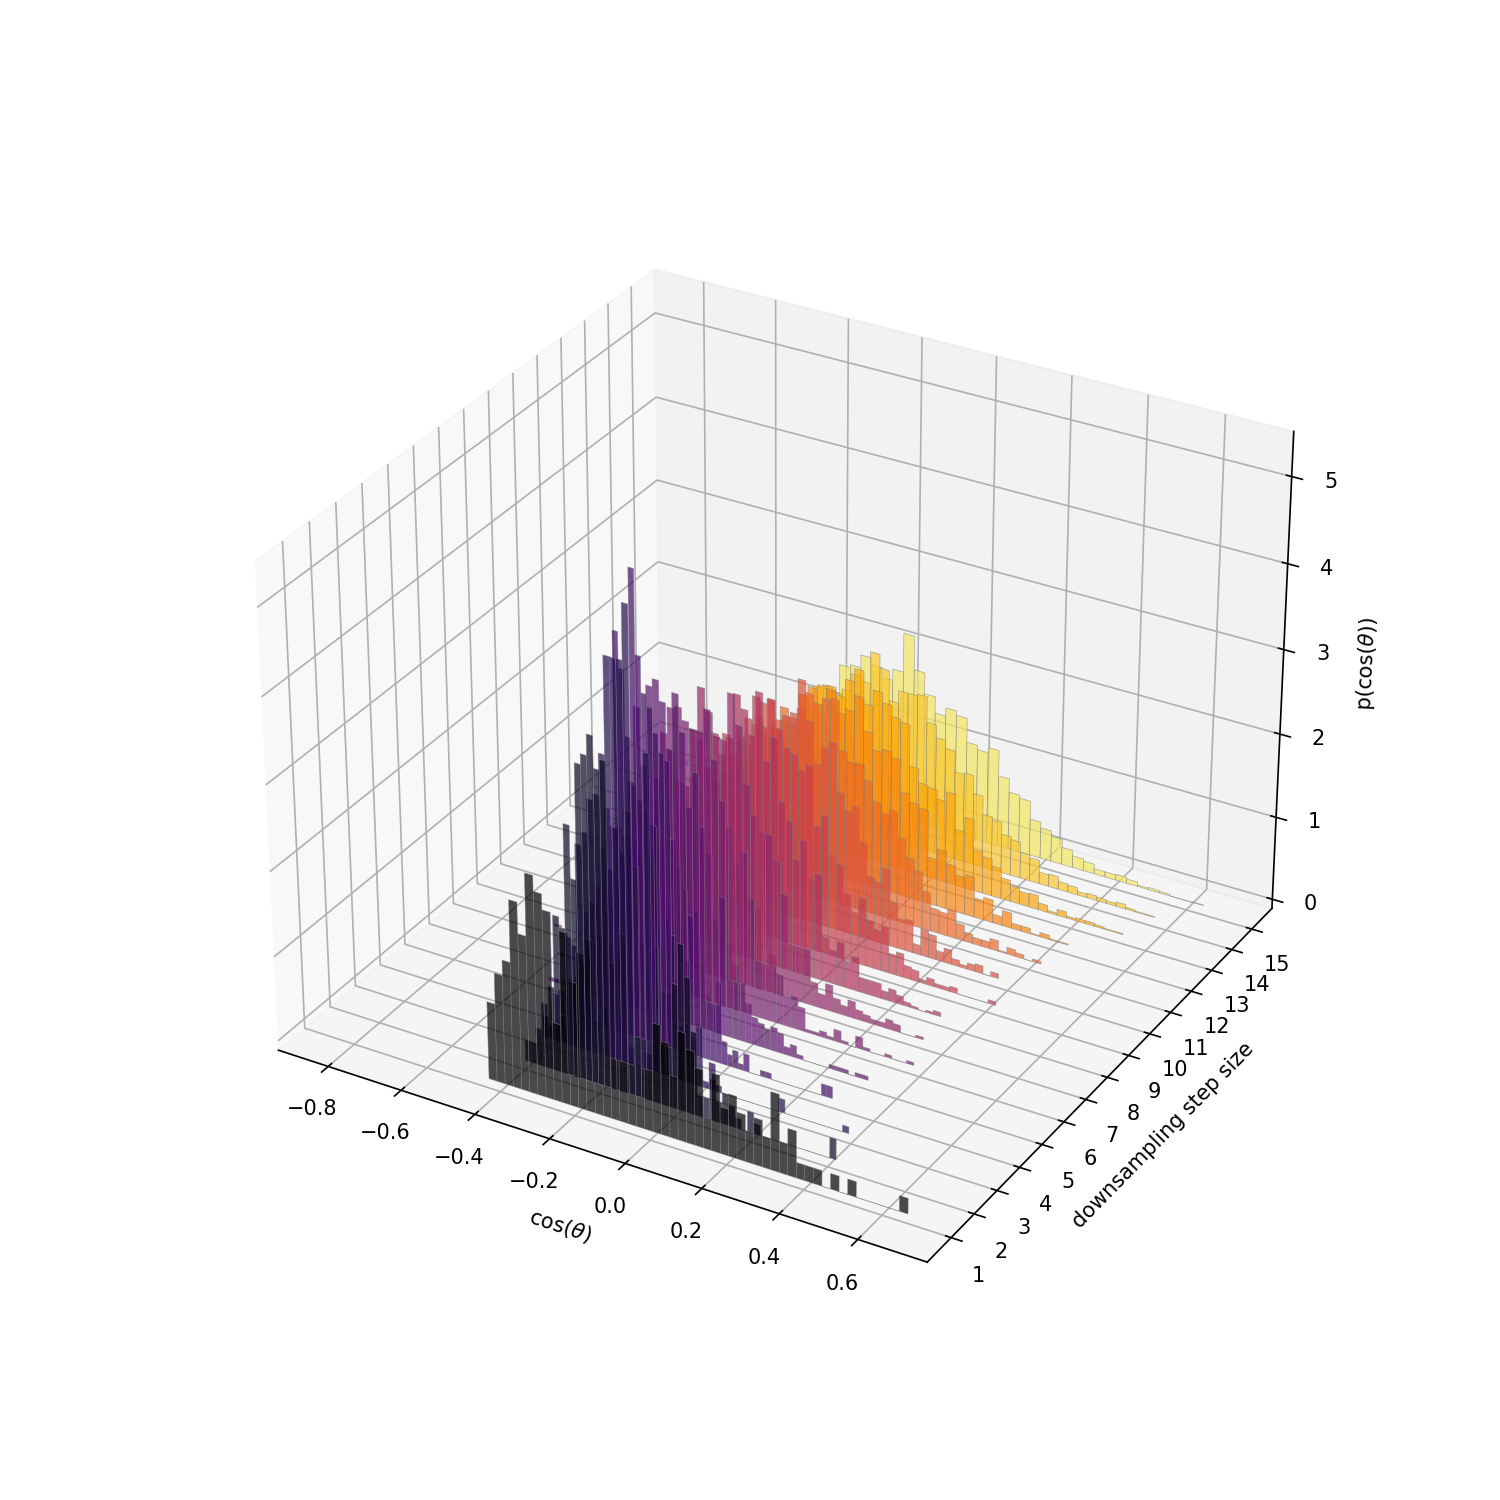

In [6]:
norm_counts, bins, sample_numbers = plot_3d(sim_cos_theta_dict,step_sizes,50,absolute=False,
                                            data_variable="cos({})".format(r'$\theta$'))

In [7]:
def get_hist_mids(bins):
    
    return 0.5*(bins[1:] + bins[:-1])

def get_hist_probs(counts,bins,biased=False):
    
    if biased==False:
        probs = counts / (np.sum(counts)-1)
    else:
        probs = counts/np.sum(counts)
        
    return probs

def get_hist_mean(probs,mids):
    
    return np.sum(mids*probs)

def get_hist_sd(probs,mids,mean):
    
    x_2 = np.sum((mids**2)*probs)
    
    return np.sqrt(x_2 - mean**2)

def get_hist_skew(probs,mids,mean,sd):
    
    return np.sum(((mids-mean)/sd)**3)

def return_stats(counts, bins):
    
    hist_probs = get_hist_probs(counts,bins)
    hist_mids = get_hist_mids(bins)
    hist_mean = get_hist_mean(hist_probs,hist_mids)
    hist_sd = get_hist_sd(hist_probs,hist_mids,hist_mean)
    hist_skew = get_hist_skew(hist_probs,hist_mids,hist_mean,hist_sd)
    
    return hist_mean,hist_sd,hist_skew

def get_stats_dict(total_counts,total_bins,sample_numbers,pandas_df=True):
    stats_dict = {}
    stats_dict['samples'] = np.empty(len(total_counts))
    stats_dict['mean'] = np.empty(len(total_counts))
    stats_dict['sd'] = np.empty(len(total_counts))
    stats_dict['skew'] = np.empty(len(total_counts))
    
    for i in np.arange(len(total_counts)):
        mean,sd,skew = return_stats(total_counts[i],total_bins[i])
        stats_dict['samples'][i] = sample_numbers[i]
        stats_dict['mean'][i] = mean
        stats_dict['sd'][i] = sd
        stats_dict['skew'][i] = skew 
        
    if not pandas_df:
        return stats_dict
    
    else:
        column_labels = np.arange(1,len(total_counts)+1)
        df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=column_labels)
        return df.apply(pd.to_numeric, downcast='integer')
    

In [8]:
stats_dict = get_stats_dict(norm_counts,bins,sample_numbers)
#stats_dict['mean'].values
sample_numbers = stats_dict.iloc[0,:].values
mean_values = stats_dict.iloc[1,:].values
sd_values = stats_dict.iloc[2,:].values
skew_values = stats_dict.iloc[3,:].values

In [9]:
stats_dict

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
samples,250.000000,500.000000,750.000000,1000.000000,1250.000000,1500.000000,1750.000000,2000.000000,2250.000000,2500.000000,2750.000000,3000.000000,3250.000000,3500.000000,3750.000000
mean,-0.102073,-0.148966,-0.195651,-0.204337,-0.206190,-0.200869,-0.194931,-0.190339,-0.183753,-0.179551,-0.175754,-0.174908,-0.173561,-0.168835,-0.167711
sd,0.227076,0.119235,0.090217,0.093427,0.109330,0.121005,0.129131,0.137577,0.151673,0.158476,0.169442,0.181918,0.191622,0.197180,0.208209
skew,327.520479,921.616039,2415.726844,1202.796824,759.561362,722.818742,262.799992,151.694851,381.760216,112.629073,119.947381,-40.539530,229.004792,243.740846,230.013378


<IPython.core.display.Javascript object>


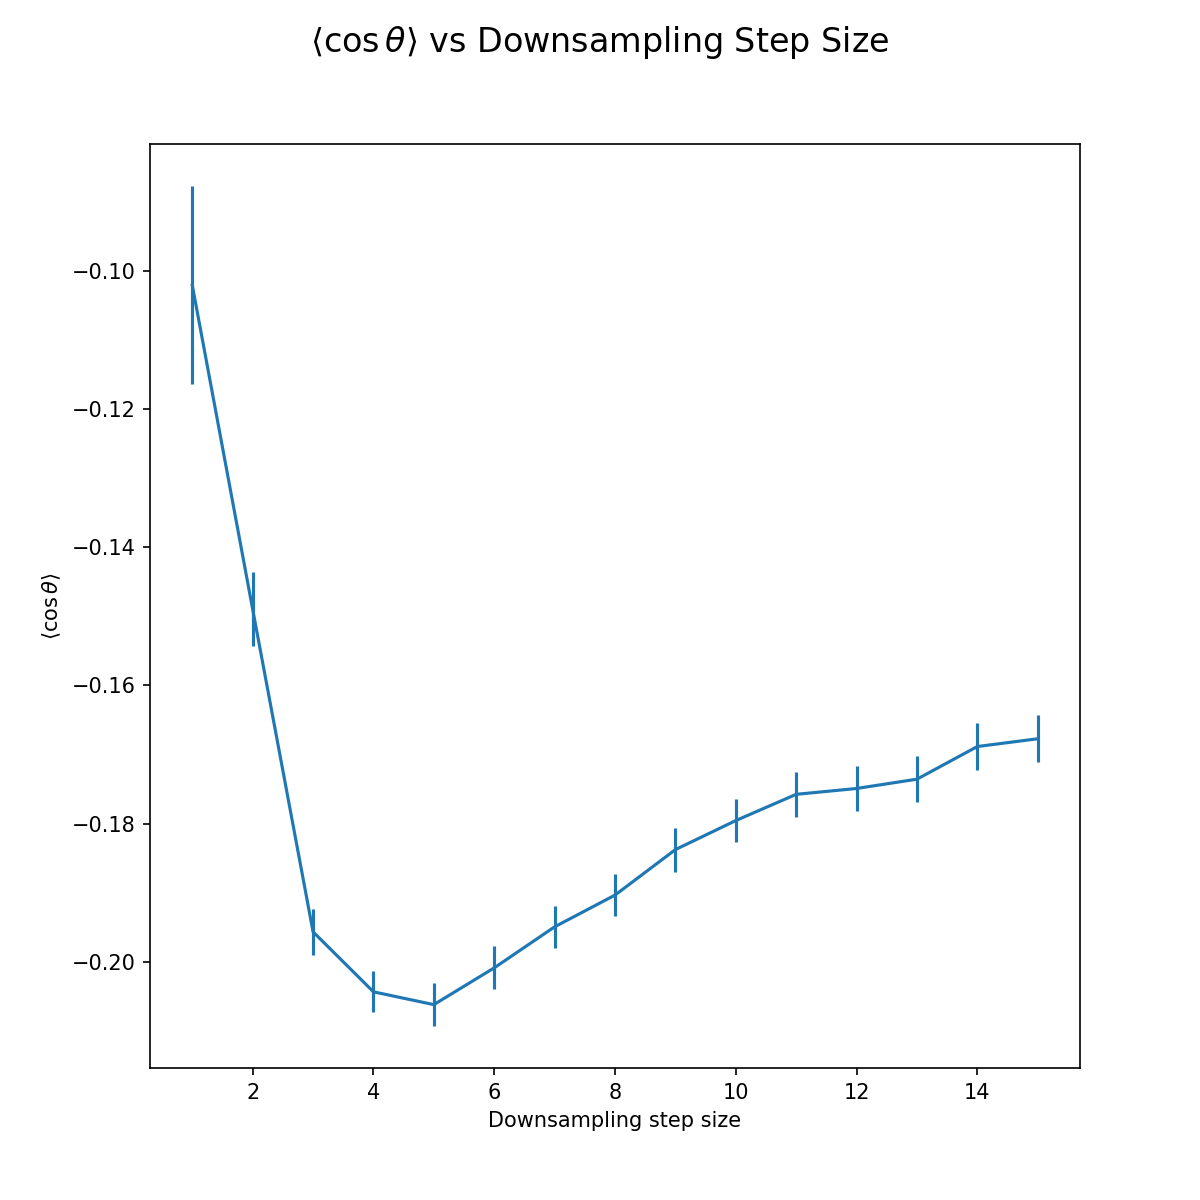

<ErrorbarContainer object of 3 artists>

In [10]:
fig,ax = plt.subplots(figsize=(8,8))
fig.suptitle("{} vs Downsampling Step Size".format(r"$\langle \cos\theta \rangle$"), fontsize=16)
ax.set_xlabel('Downsampling step size')
ax.set_ylabel("{}".format(r"$\langle \cos\theta \rangle$"))
ax.errorbar(x=step_sizes,y=mean_values,yerr=sd_values/np.sqrt(sample_numbers))

# Multi-panel plotting

## Average parameter vs time

Parameter can be $\cos\theta$ or $H$.

In [35]:
def subplot_avg_vs_time(ax, file_name, data_dict, step_sizes, nbins, pos, window=None, restriction=None, batch_number=None,
                        subplot_title=None, label=None):
    """
    data_dict can be 'h_dict', 'cos_theta_dict', 'sim_cos_theta_dict'.
    """
    i,j = pos
    
    dictionary = get_dict_from_file(file_name, data_dict, step_sizes, window=window, restriction=restriction,
                                    batch_number=batch_number)
    norm_counts, bins, sample_numbers = get_hist(dictionary, nbins, absolute=False)
    stats_dict = get_stats_dict(norm_counts, bins, sample_numbers)
    sample_numbers = stats_dict.iloc[0,:].values
    mean_values = stats_dict.iloc[1,:].values
    sd_values = stats_dict.iloc[2,:].values
    
    ax[i,j].set_xticks(step_sizes)
    ax[i,j].set_xlabel('downsampling step size')
    
    if label==None:
        ax[i,j].errorbar(x=step_sizes,y=mean_values,yerr=sd_values/np.sqrt(sample_numbers))
    else:
        ax[i,j].errorbar(x=step_sizes,y=mean_values,yerr=sd_values/np.sqrt(sample_numbers), label=label)
    
    if data_dict=='cos_theta_dict' or data_dict=='sim_cos_theta_dict':
        ax[i,j].set_ylabel(r'$\langle \cos\theta \rangle$')
    elif data_dict=='h_dict':
        ax[i,j].set_ylabel(r'$\langle H \rangle$')
    
    if subplot_title==None:
        ax[i,j].set_title(file_name)
    else:
        ax[i,j].set_title(subplot_title)
        
def multi_panel_plot_avg_vs_time(filenames, data_dict, step_sizes, nbins, ncols=3, window=None, restriction=None,
                                 batch_number=None, title=None, subplot_titles=None, figsize=None):
    """
    """
    nrows = len(filenames)//ncols + (len(filenames) % ncols > 0)
    
    if figsize==None:
        figsize = (4*ncols, 4*nrows)
        
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, constrained_layout=True)
    
    if title!=None:
        fig.suptitle(title, fontsize=16)
    
    i, j = 0, 0
    for f_index, f_name in enumerate(filenames):

        if subplot_titles==None:
            subplot_avg_vs_time(ax, f_name, data_dict, step_sizes, nbins, [i,j], window=window, restriction=restriction, 
                                batch_number=batch_number, subplot_title=f_name)
        else:
            subplot_avg_vs_time(ax, f_name, data_dict, step_sizes, nbins, [i,j], window=window, restriction=restriction, 
                    batch_number=batch_number, subplot_title=subplot_titles[f_index])
        j+=1
        if j==3:
            i+=1
            j=0

    return fig

def combined_multi_panel_plot_avg_vs_time(filenames_arr, data_dict, step_sizes, nbins, ncols=3, window=None, restriction=None,
                                          batch_number=None, title=None, subplot_titles=None, labels=None, figsize=None):
    """
    filenames_arr should be 2D array
    """
    nrows = len(filenames_arr[0])//ncols + (len(filenames_arr[0]) % ncols > 0)
    
    if figsize==None:
        figsize = (4*ncols, 4*nrows)
        
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, constrained_layout=True)
    
    if title!=None:
        fig.suptitle(title, fontsize=16)
        
    if subplot_titles==None:
        subplot_titles = np.repeat('', len(filenames_arr[0]))
    if labels==None:
        labels = np.repeat('', len(filenames_arr[0]))
    
    i, j = 0, 0
    for f_index in range(len(filenames_arr[0])):
        
        for arr_index, files in enumerate(filenames_arr):
            subplot_avg_vs_time(ax, files[f_index], data_dict, step_sizes, nbins, [i,j], window=window,
                                restriction=restriction, batch_number=batch_number, subplot_title=subplot_titles[f_index],
                                label=labels[arr_index])
            if labels!=None:
                ax[i,j].legend()
        j+=1
        if j==3:
            i+=1
            j=0

    return fig

### Simulated data: $\langle\cos\theta\rangle$ vs time plots

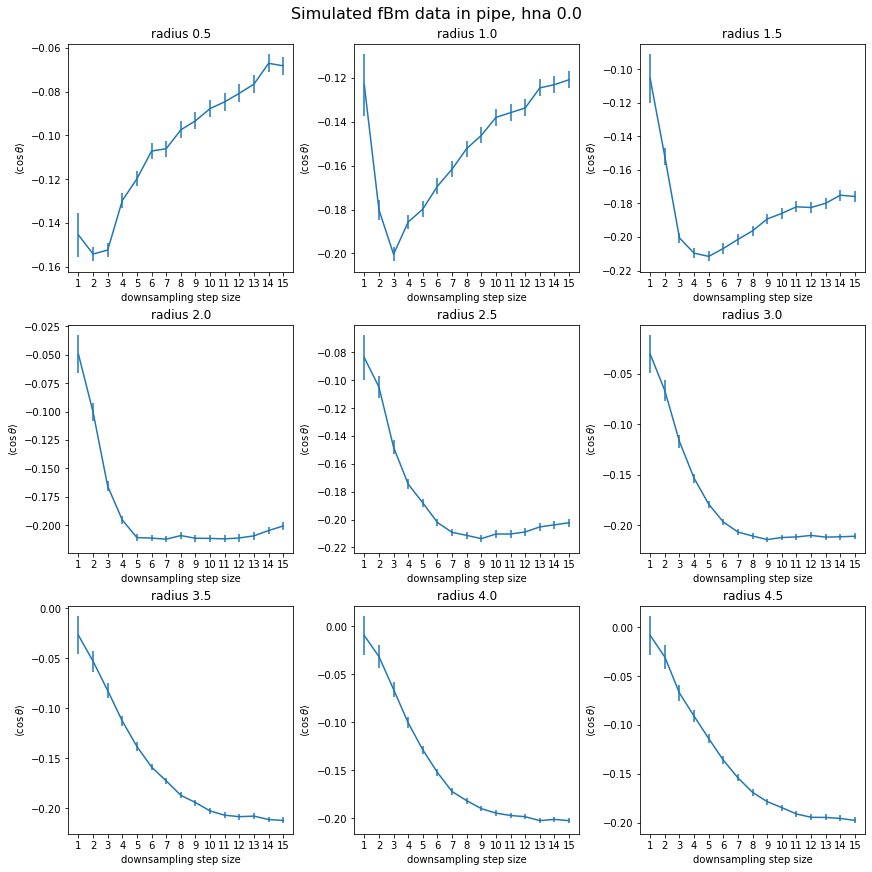

In [36]:
# Simulated data, hna 0.0
%matplotlib inline
batch_number=1
step_sizes=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

fnames = filenames_sim_stoch_hna00[0:9]
fig_title = 'Simulated fBm data in pipe, hna 0.0'
radii = np.arange(0.5, 10.5, 0.5)[:len(fnames)]
sub_titles = ['radius '+str(radius) for radius in radii]
fig = multi_panel_plot_avg_vs_time(fnames, 'sim_cos_theta_dict', step_sizes, 20, ncols=3, window=None, restriction=None, 
                                   batch_number=batch_number, title=fig_title, subplot_titles=sub_titles)
plt.savefig('sim_cos_theta_plots/'+'sim_cos_theta_time_plot'+'_hna00'+'_s{}'.format(max(step_sizes))+'_b{}'.format(batch_number), dpi=300, facecolor='white')

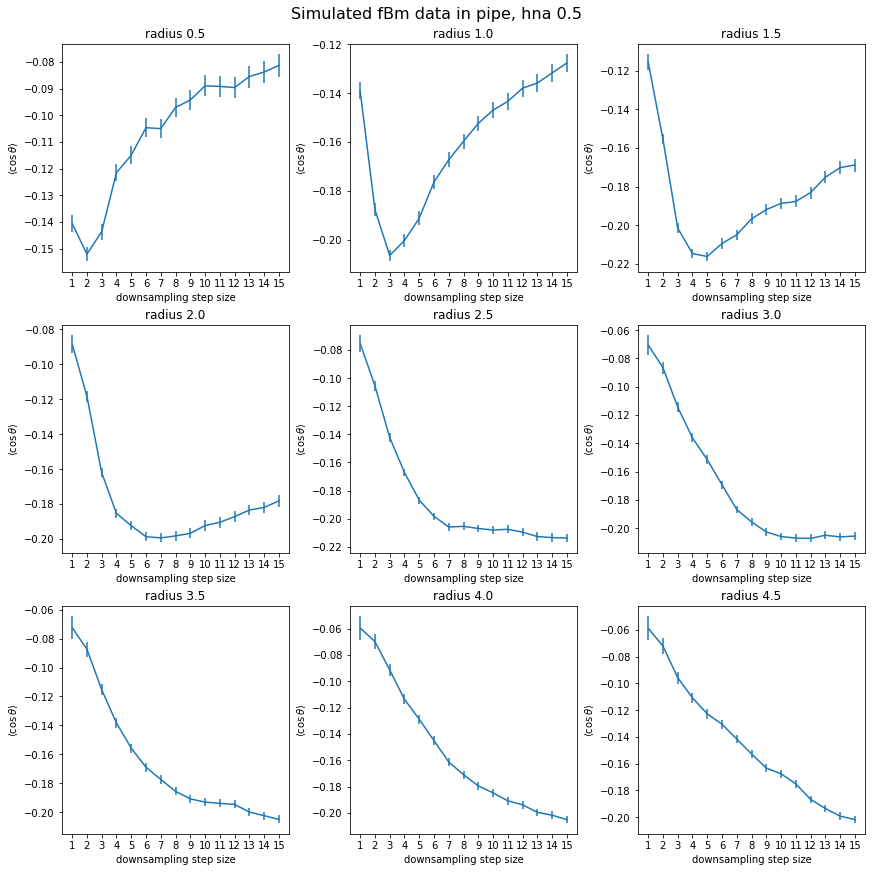

In [37]:
# Simulated data, hna 0.5
%matplotlib inline
batch_number=1
step_sizes=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

fnames = filenames_sim_stoch_hna05[0:9]
fig_title = 'Simulated fBm data in pipe, hna 0.5'
radii = np.arange(0.5, 10.5, 0.5)[:len(fnames)]
sub_titles = ['radius '+str(radius) for radius in radii]
fig = multi_panel_plot_avg_vs_time(fnames, 'sim_cos_theta_dict', step_sizes, 20, ncols=3, window=None, restriction=None, 
                                   batch_number=batch_number, title=fig_title, subplot_titles=sub_titles)
plt.savefig('sim_cos_theta_plots/'+'sim_cos_theta_time_plot'+'_hna05'+'_s{}'.format(max(step_sizes))+'_b{}'.format(batch_number), dpi=300, facecolor='white')

### Experimental data: $\langle\cos\theta\rangle$ vs time plots

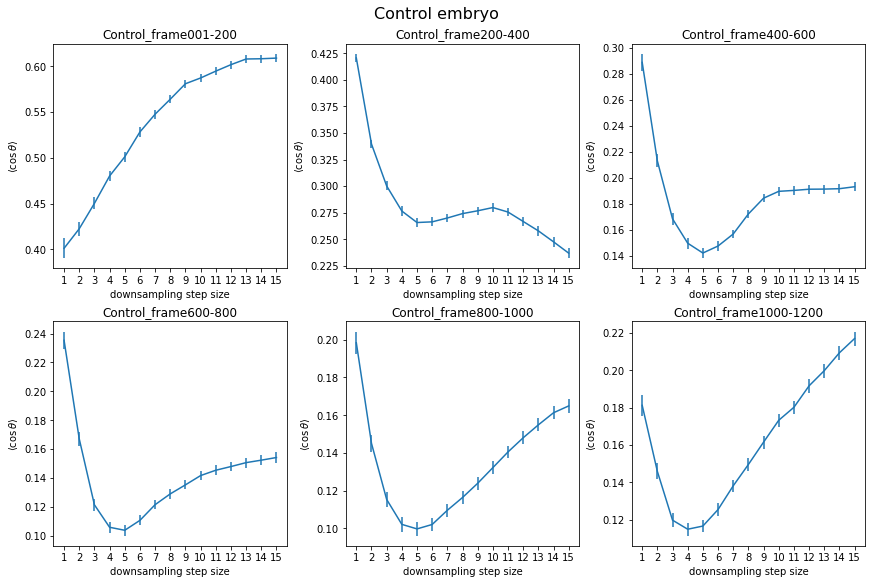

In [38]:
filenames_control = np.array(['Control_frame001-200', 'Control_frame200-400', 'Control_frame400-600', 'Control_frame600-800',
                              'Control_frame800-1000', 'Control_frame1000-1200'])
%matplotlib inline
batch_number=1
step_sizes=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

fnames = filenames_control
fig_title = 'Control embryo'
fig = multi_panel_plot_avg_vs_time(fnames, 'cos_theta_dict', step_sizes, 20, ncols=3, window=None, restriction=None, 
                                   batch_number=batch_number, title=fig_title)
plt.savefig('cos_theta_plots/'+'cos_theta_time_plot_'+'Control'+'_s{}'.format(max(step_sizes))+'_b{}'.format(batch_number), dpi=300, facecolor='white')

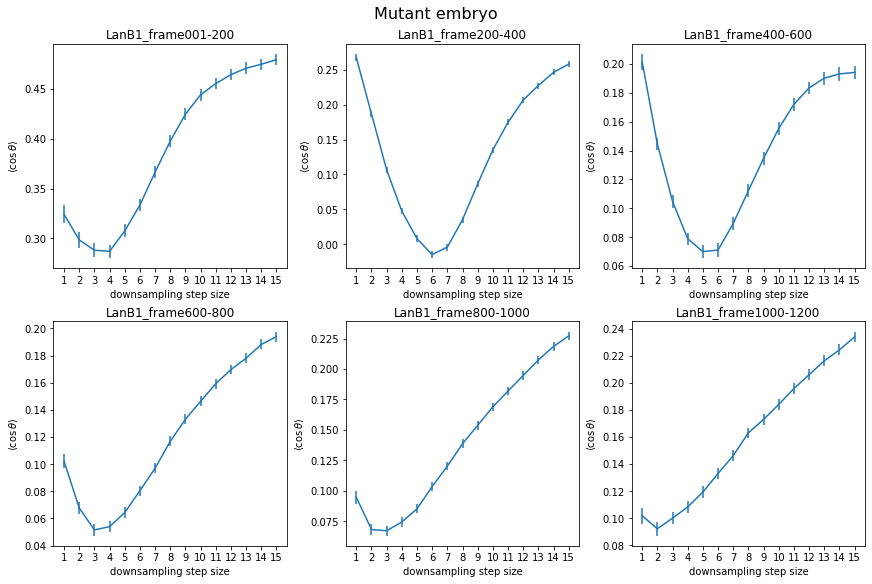

In [39]:
filenames_mutant = np.array(['LanB1_frame001-200', 'LanB1_frame200-400', 'LanB1_frame400-600', 'LanB1_frame600-800',
                             'LanB1_frame800-1000', 'LanB1_frame1000-1200'])
%matplotlib inline
batch_number=1
step_sizes=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

fnames = filenames_mutant
fig_title = 'Mutant embryo'
fig = multi_panel_plot_avg_vs_time(fnames, 'cos_theta_dict', step_sizes, 20, ncols=3, window=None, restriction=None, 
                                   batch_number=batch_number, title=fig_title)
plt.savefig('cos_theta_plots/'+'cos_theta_time_plot_'+'LanB1'+'_s{}'.format(max(step_sizes))+'_b{}'.format(batch_number), dpi=300, facecolor='white')

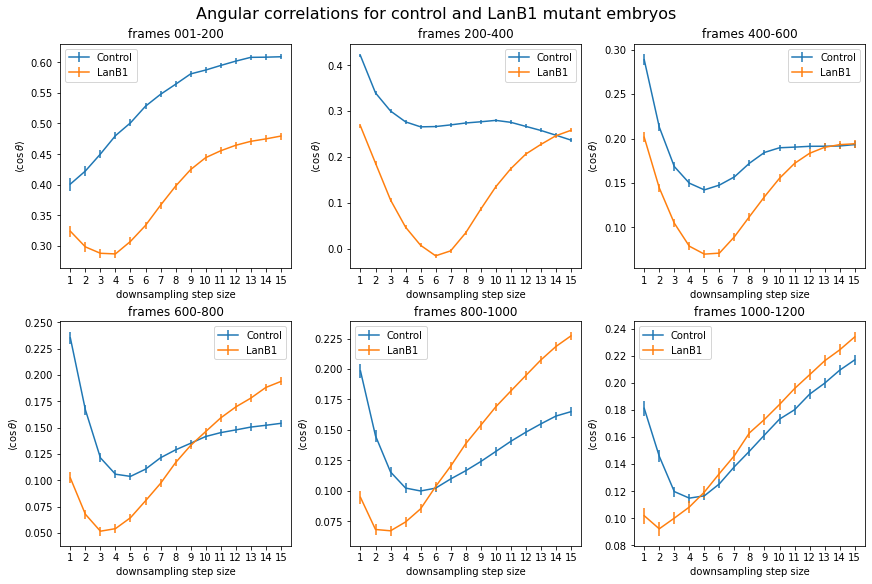

In [41]:
#combined plot
%matplotlib inline
batch_number=1
step_sizes=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

fnames_arr = np.array([filenames_control, filenames_mutant])
fig_title = 'Angular correlations for control and LanB1 mutant embryos'
sub_titles = ['frames 001-200', 'frames 200-400', 'frames 400-600', 'frames 600-800', 'frames 800-1000', 'frames 1000-1200']
labels = ['Control', 'LanB1']
fig = combined_multi_panel_plot_avg_vs_time(fnames_arr, 'cos_theta_dict', step_sizes, 20, ncols=3, window=None,
                                            restriction=None, batch_number=batch_number, title=fig_title,
                                            subplot_titles=sub_titles, labels=labels)
plt.savefig('cos_theta_plots/'+'cos_theta_time_plot_'+'combined'+'_s{}'.format(max(step_sizes))+'_b{}'.format(batch_number), dpi=300, facecolor='white')

### Experimental data: $\langle H \rangle$ vs time plots

In [ ]:
filenames_control = np.array(['Control_frame001-200', 'Control_frame200-400', 'Control_frame400-600', 'Control_frame600-800',
                              'Control_frame800-1000', 'Control_frame1000-1200'])
%matplotlib inline
step_sizes=[1,2,3,4,5,6,7,8]
window=20
restriction=10000

fnames = filenames_control
fig_title = 'Control embryo'
fig = multi_panel_plot_avg_vs_time(fnames, 'h_dict', step_sizes, 20, ncols=3, window=window, restriction=restriction, 
                                   batch_number=None, title=fig_title)
plt.savefig('hurst_plots/'+'hurst_time_plot_'+'Control_'+'w{}_s{}_r{}_'.format(window, max(step_sizes), restriction), dpi=300, facecolor='white')

In [ ]:
filenames_mutant = np.array(['LanB1_frame001-200', 'LanB1_frame200-400', 'LanB1_frame400-600', 'LanB1_frame600-800',
                             'LanB1_frame800-1000', 'LanB1_frame1000-1200'])
%matplotlib inline
step_sizes=[1,2,3,4,5,6,7,8]
window=20
restriction=10000

fnames = filenames_mutant[0:5]
fig_title = 'Mutant embryo'
fig = multi_panel_plot_avg_vs_time(fnames, 'h_dict', step_sizes, 20, ncols=3, window=window, restriction=restriction, 
                                   batch_number=None, title=fig_title)
plt.savefig('hurst_plots/'+'hurst_time_plot_'+'Mutant_'+'w{}_s{}_r{}_'.format(window, max(step_sizes), restriction), dpi=300, facecolor='white')

## Histogram 2D

In [ ]:
def subplot_hist_2d(ax, file_name, data_dict, all_step_sizes, step_sizes_plot, nbins, pos, window=None, restriction=None,
                    batch_number=None, subplot_title=None):
    """
    """
    i, j = pos
    
    dictionary = get_dict_from_file(file_name, data_dict, step_sizes, window=window, restriction=restriction,
                                    batch_number=batch_number)
    
    cmap = plt.cm.plasma
    
    for s in step_sizes_plot:
        ax[i,j].hist(dictionary[str(s)], nbins, density=True, histtype='step', label='step size {}'.format(s),
                     color=cmap((s-1)/len(all_step_sizes)))
    ax[i,j].legend(loc='upper left')
    
    if data_dict == 'cos_theta_dict' or data_dict == 'sim_cos_theta_dict':
        ax[i,j].set_xlabel(r'$\cos\theta$')
        ax[i,j].set_ylabel(r'p($\cos\theta$)')
    if data_dict == 'h_dict':
        ax[i,j].set_xlabel('H')
        ax[i,j].set_ylabel('p(H)')
        
    if subplot_title==None:
        ax[i,j].set_title(file_name)
    else:
        ax[i,j].set_title(subplot_title)

def multi_panel_plot_hist_2d(filenames, data_dict, all_step_sizes, step_sizes_plot, nbins, ncols=3, window=None, 
                             restriction=None, batch_number=None, title=None, subplot_titles=None, figsize=None):
    """
    """
    nrows = len(filenames)//ncols + (len(filenames) % ncols > 0)
    
    if figsize==None:
        figsize = (4*ncols, 4*nrows)
        
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, constrained_layout=True)
    
    if title!=None:
        fig.suptitle(title, fontsize=16)
        
    i, j = 0, 0
    for f_index, f_name in enumerate(filenames):

        if subplot_titles==None:
            subplot_hist_2d(ax, f_name, data_dict, all_step_sizes, step_sizes_plot, nbins, [i,j], window=window, 
                            restriction=restriction, batch_number=batch_number, subplot_title=f_name)
        else:
            subplot_hist_2d(ax, f_name, data_dict, all_step_sizes, step_sizes_plot, nbins, [i,j], window=window, 
                            restriction=restriction, batch_number=batch_number, subplot_title=subplot_titles[f_index])
        j+=1
        if j==3:
            i+=1
            j=0

    return fig

### Simulated data: $p(\cos\theta)$ histogram 2D

In [ ]:
filenames_sim_stoch_hna00 = np.array(['stoch_h_hna0.00_r0.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r1.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r1.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r2.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r2.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r3.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r3.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r4.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r4.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r5.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r5.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r6.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r6.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r7.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r7.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r8.50_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r9.00_l200_mc250_cylinder_data',
                                      'stoch_h_hna0.00_r9.50_l200_mc250_cylinder_data'])
%matplotlib inline
step_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plot_ss = [1,7,15]
nbins = 20
batch_number = 1

fnames = filenames_sim_stoch_hna00
fig_title = 'Simulated fBm data in pipe, hna 0.0'
radii = np.arange(0.5, 10.5, 0.5)[:len(fnames)]
sub_titles = ['radius '+str(radius) for radius in radii]
fig = multi_panel_plot_hist_2d(fnames, 'sim_cos_theta_dict', step_sizes, plot_ss, nbins, ncols=3, window=None, 
                               restriction=None, batch_number=batch_number, title=fig_title, subplot_titles=sub_titles)
plt.savefig('sim_cos_theta_plots/'+'sim_cos_theta_hist_plot'+'_hna00'+'_s{}'.format(max(step_sizes))+'_b{}'.format(batch_number), dpi=300, facecolor='white')

### Experimental data: $p(\cos\theta)$ histogram 2D

In [ ]:
filenames_control = np.array(['Control_frame001-200', 'Control_frame200-400', 'Control_frame400-600', 'Control_frame600-800',
                              'Control_frame800-1000', 'Control_frame1000-1200'])
%matplotlib inline
step_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plot_ss = [1,7,15]
nbins = 20
batch_number = 1

fnames = filenames_control
fig_title = 'Control embryo'
fig = multi_panel_plot_hist_2d(fnames, 'cos_theta_dict', step_sizes, plot_ss, nbins, ncols=3, window=None, 
                               restriction=None, batch_number=batch_number, title=fig_title)
plt.savefig("cos_theta_plots/cos_theta_hist_plot_Control_s{}_b{}".format( max(step_sizes), batch_number), dpi=300,facecolor='white')

In [ ]:
filenames_mutant = np.array(['LanB1_frame001-200', 'LanB1_frame200-400', 'LanB1_frame400-600', 'LanB1_frame600-800',
                             'LanB1_frame800-1000', 'LanB1_frame1000-1200'])

%matplotlib inline
step_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plot_ss = [1,7,15]
nbins = 20
batch_number = 1

fnames = filenames_mutant
fig_title = 'Mutant embryo'
fig = multi_panel_plot_hist_2d(fnames, 'cos_theta_dict', step_sizes, plot_ss, nbins, ncols=3, window=None, 
                               restriction=None, batch_number=batch_number, title=fig_title)
plt.savefig("cos_theta_plots/cos_theta_hist_plot_Mutant_s{}_b{}".format( max(step_sizes), batch_number), dpi=300,facecolor='white')

### Experimental data: $p(H)$ histogram 2D

In [ ]:
filenames_control = np.array(['Control_frame001-200', 'Control_frame200-400', 'Control_frame400-600', 'Control_frame600-800',
                              'Control_frame800-1000', 'Control_frame1000-1200'])
%matplotlib inline
step_sizes = [1,2,3,4,5,6,7,8]
plot_ss = [1,4,8]
window = 20
restriction = 10000
nbins = 20

fnames = filenames_control
fig_title = 'Control embryo'
fig = multi_panel_plot_hist_2d(fnames, 'h_dict', step_sizes, plot_ss, nbins, ncols=3, window=window, 
                               restriction=restriction, batch_number=None, title=fig_title)
plt.savefig("hurst_plots/hurst_hist_plot_Control_w{}_s{}_r{}".format(window, max(step_sizes), restriction), dpi=300, 
            facecolor='white')

In [ ]:
filenames_mutant = np.array(['LanB1_frame001-200', 'LanB1_frame200-400', 'LanB1_frame400-600', 'LanB1_frame600-800',
                             'LanB1_frame800-1000', 'LanB1_frame1000-1200'])
%matplotlib inline
step_sizes = [1,2,3,4,5,6,7,8]
plot_ss = [1,4,8]
window = 20
restriction = 10000
nbins = 20

fnames = filenames_mutant[0:5]
fig_title = 'Mutant embryo'
fig = multi_panel_plot_hist_2d(fnames, 'h_dict', step_sizes, plot_ss, nbins, ncols=3, window=window, 
                               restriction=restriction, batch_number=None, title=fig_title)
plt.savefig("hurst_plots/hurst_hist_plot_Mutant_w{}_s{}_r{}".format(window, max(step_sizes), restriction), dpi=300, 
            facecolor='white')

### Code for mixture modelling - unused

def optimum_components(data,n_max,plot=0):
    bics = []
    aics = []
    min_bic = 0
    min_aic = 0
    b_counter=1
    a_counter=1
    for i in np.arange(1,n_max-1): # test the AIC/BIC metric between 1 and 10 components
        gmm = GMM(n_components = i, max_iter=1000, random_state=10, covariance_type = 'full')
        labels = gmm.fit(data).predict(data)
        bic = gmm.bic(data)
        aic = gmm.aic(data)
        bics.append(bic)
        aics.append(aic)
        if bic < min_bic or min_bic == 0:
            min_bic = bic
            opt_bic = b_counter
        b_counter +=1
        if aic < min_aic or min_aic == 0:
            min_aic = aic
            opt_aic = a_counter
        a_counter +=1
    
    if plot==1:    
        fig,ax = plt.subplots(figsize=(10, 4))
        # Plot 1
        plt.plot(np.arange(1,n_max-1), bics, 'o-', lw=3, c='black', label='BIC')
        plt.plot(np.arange(1,n_max-1), aics, 'o-', lw=3, label='AIC')
        plt.legend(frameon=False, fontsize=15)
        plt.xlabel('Number of components', fontsize=12)
        plt.ylabel('Bayesian Information criterion', fontsize=12)
        plt.xticks(np.arange(0,n_max, 2))
        plt.title('Opt. components = '+str(opt_bic), fontsize=20)
        plt.show()

    return opt_bic,bics,opt_aic,aics

### Scrap code

def get_dict_from_file(file_name, window, step_sizes, restriction,
                       path='h_dict_data/',full_file_name=None):
    """
    Reads in dictionary of H values.
    """
    try:
        with open(path+'h_dict_'+'w{}_'.format(window)+'s{}_'.format(max(step_sizes))+'r{}_'.format(restriction)+file_name, 'r') as file:
            h_dict = file.read()
    except FileNotFoundError:
        with open(path+'h_dict_'+'w{}_'.format(window)+'s{}_'.format(max(step_sizes))+'r{}_'.format(restriction)+file_name+'.txt', 'r') as file:
            h_dict = file.read()
        
    return json.loads(h_dict)


a, b = 0.97,.99
fig,ax = plt.subplots(figsize=(8,8))
x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
ax.plot(x, beta.pdf(x, a, b),
       'r-', lw=5, alpha=0.6, label='beta pdf')

def plot_hist_2d(file_name, data_dict, all_step_sizes, step_sizes_plot, nbins, window=None, restriction=None,
                 batch_number=None):
    """
    """
    dictionary = get_dict_from_file(file_name, 'cos_theta_dict', step_sizes, window=None, restriction=None,
                                    batch_number=batch_number)
    
    cmap = plt.cm.plasma
    
    for s in step_sizes_plot:
        plt.hist(dictionary[str(s)], nbins, density=True, histtype='step', label='step size {}'.format(s),
                 color=cmap((s-1)/len(all_step_sizes)))
    plt.legend(loc='upper left')
    plt.xlabel('H')
    plt.ylabel('p(H)')
    plt.title(file_name)

In [ ]:
# def subplot_costheta_time(file_name, step_sizes, batch_number, nbins, pos, subplot_title=None):
#     """
#     """
#     i, j = pos
    
#     cos_theta_dict = get_dict_from_file(file_name, 'sim_cos_theta_dict', step_sizes, window=None, restriction=None,
#                                         batch_number=batch_number)
    
#     norm_counts, bins, sample_numbers = get_hist(cos_theta_dict,nbins,absolute=False)
#     stats_dict = get_stats_dict(norm_counts,bins,sample_numbers)
#     sample_numbers = stats_dict.iloc[0,:].values
#     mean_values = stats_dict.iloc[1,:].values
#     sd_values = stats_dict.iloc[2,:].values
    
#     ax[i,j].errorbar(x=step_sizes,y=mean_values,yerr=sd_values/np.sqrt(sample_numbers))
#     ax[i,j].set_xticks(step_sizes)
#     ax[i,j].set_xlabel('downsampling step size')
#     ax[i,j].set_ylabel(r'$\langle \cos\theta \rangle$')
#     if subplot_title==None:
#         ax[i,j].set_title(file_name)
#     else:
#         ax[i,j].set_title(subplot_title)

In [ ]:
# %matplotlib inline
# batch_number=1
# step_sizes=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# radii = np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5])

# #simulated data hna 0.0
# fig, ax = plt.subplots(3, 3, figsize=(12, 12), constrained_layout=True)
# fig.suptitle("Simulated fBm data in pipe, hna 0.0", fontsize=16)
# # batch 1
# for j, file in enumerate(filenames_sim_stoch_hna00[0:3]):
#     subplot_costheta_time(file, step_sizes, batch_number=batch_number, nbins=20, pos=[0,j], subplot_title='radius '+str(radii[0:3][j]))
# for j, file in enumerate(filenames_sim_stoch_hna00[3:6]):
#     subplot_costheta_time(file, step_sizes, batch_number=batch_number, nbins=20, pos=[1,j], subplot_title='radius '+str(radii[3:6][j]))
# for j, file in enumerate(filenames_sim_stoch_hna00[6:9]):
#     subplot_costheta_time(file, step_sizes, batch_number=batch_number, nbins=20, pos=[2,j], subplot_title='radius '+str(radii[6:9][j]))
# plt.savefig('sim_costheta_time_plots/'+'sim_costheta_time_plot'+'_hna00'+'_s{}'.format(max(step_sizes))+'_b{}'.format(batch_number), dpi=300, facecolor='white')

In [ ]:
# #simulated data hna 0.5
# fig, ax = plt.subplots(3, 3, figsize=(12, 12), constrained_layout=True)
# fig.suptitle("Simulated fBm data in pipe, hna 0.5".format(batch_number), fontsize=16)
# # batch 1
# for j, file in enumerate(filenames_sim_stoch_hna05[0:3]):
#     subplot_costheta_time(file, step_sizes, batch_number=batch_number, nbins=20, pos=[0,j], subplot_title='radius '+str(radii[0:3][j]))
# for j, file in enumerate(filenames_sim_stoch_hna05[3:6]):
#     subplot_costheta_time(file, step_sizes, batch_number=batch_number, nbins=20, pos=[1,j], subplot_title='radius '+str(radii[3:6][j]))
# for j, file in enumerate(filenames_sim_stoch_hna05[6:9]):
#     subplot_costheta_time(file, step_sizes, batch_number=batch_number, nbins=20, pos=[2,j], subplot_title='radius '+str(radii[6:9][j]))
# plt.savefig('sim_costheta_time_plots/'+'sim_costheta_time_plot'+'hna05'+'_s{}'.format(max(step_sizes))+'_b{}'.format(batch_number), dpi=300, facecolor='white')


In [ ]:
# def six_panel_plot(step_sizes, plot_ss, nbins, haemocyte_type, filenames, batch_number):

#     fig, ax = plt.subplots(2, 3, figsize=(10, 12), constrained_layout=True)

#     fig.suptitle(haemocyte_type, fontsize=16)

#     subplot_hist_2d(filenames[0], step_sizes, plot_ss, nbins, batch_number, [0,0])
#     subplot_hist_2d(filenames[1], step_sizes, plot_ss, nbins, batch_number, [0,1])
#     subplot_hist_2d(filenames[2], step_sizes, plot_ss, nbins, batch_number, [0,2])
#     subplot_hist_2d(filenames[3], step_sizes, plot_ss, nbins, batch_number, [1,0])
#     subplot_hist_2d(filenames[4], step_sizes, plot_ss, nbins, batch_number, [1,1])
#     subplot_hist_2d(filenames[5], step_sizes, plot_ss, nbins, batch_number, [1,2])
    
#     plt.show()

In [ ]:
# # Control embryo 2D histogram plots
# %matplotlib inline
# step_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# #step_sizes= [1,2,3,4,5,6,7,8]
# plot_ss = [1,7,15]
# #plot_ss = [1,4,8]
# nbins = 20
# batch_number = 1

# fig, ax = plt.subplots(2, 3, figsize=(12, 8),constrained_layout=True)

# fig.suptitle("Control embryo", fontsize=16)

# subplot_hist_2d(filenames_control[0], step_sizes, plot_ss, nbins,batch_number, [0,0])
# subplot_hist_2d(filenames_control[1], step_sizes, plot_ss, nbins,batch_number, [0,1])
# subplot_hist_2d(filenames_control[2], step_sizes, plot_ss, nbins,batch_number, [0,2])
# subplot_hist_2d(filenames_control[3], step_sizes, plot_ss, nbins,batch_number, [1,0])
# subplot_hist_2d(filenames_control[4], step_sizes, plot_ss, nbins,batch_number, [1,1])
# subplot_hist_2d(filenames_control[5], step_sizes, plot_ss, nbins,batch_number, [1,2])

# #step_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# #six_panel_plot(step_sizes,[1,7,15],20,'Control Embryo',filenames_control,1)
# plt.savefig("cos_theta_plots/cos_theta_hist_s{}_b{}".format( max(step_sizes), batch_number), dpi=300,facecolor='white')

In [ ]:
# %matplotlib inline
# step_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# #step_sizes= [1,2,3,4,5,6,7,8]
# plot_ss = [1,7,15]
# #plot_ss = [1,4,8]
# nbins = 20
# batch_number = 2

# fig, ax = plt.subplots(2, 3, figsize=(12, 8),constrained_layout=True)

# fig.suptitle("Mutant embryo", fontsize=16)

# subplot_hist_2d(filenames_mutant[0], step_sizes, plot_ss, nbins,batch_number, [0,0])
# subplot_hist_2d(filenames_mutant[1], step_sizes, plot_ss, nbins,batch_number, [0,1])
# subplot_hist_2d(filenames_mutant[2], step_sizes, plot_ss, nbins,batch_number, [0,2])
# subplot_hist_2d(filenames_mutant[3], step_sizes, plot_ss, nbins,batch_number, [1,0])
# subplot_hist_2d(filenames_mutant[4], step_sizes, plot_ss, nbins,batch_number, [1,1])
# subplot_hist_2d(filenames_mutant[5], step_sizes, plot_ss, nbins,batch_number, [1,2])


In [ ]:
p_dict = get_dict_from_file(filenames[8], 'p_dict', np.arange(1,9),window=20, restriction=10000)
plot_3d(p_dict, np.arange(1,9), 200,data_variable="P",absolute=False)
p_dict['5']==p_dict['3']